In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax import config
from jax.flatten_util import ravel_pytree
from jax.nn import relu, elu
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

# New Section

In [2]:
# Define MLP
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


In [3]:
###################################################################################################################
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, v,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        self.v = v

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True) #False
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        v = self.v[idx,:]
        # Construct batch
        inputs = (u, y, v)
        outputs = s
        return inputs, outputs

In [4]:
# Define Physics-informed DeepONet model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps=2000,decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, t, x, v):
        branch_params, trunk_params = params
        # print(t.size, x.size, v.squeeze().size)
        # print(t.shape, x.shape, v.squeeze().shape)
        y = np.stack([t,x,v.squeeze()])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return   outputs

    # Define ds/dx
    def s_x_net(self, params, u, t, x, v):
         s_x = grad(self.operator_net, argnums=3)(params, u, t, x, v)
         return s_x

    # Define PDE residual
    def residual_net(self, params, u, t, x, v):
        s = self.operator_net(params, u, t, x, v)
        s_t = grad(self.operator_net, argnums=2)(params, u, t, x, v)
        s_x = grad(self.operator_net, argnums=3)(params, u, t, x, v)
        s_xx= grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x, v)

        res = s_t + s * s_x - v * s_xx
        return res

    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y, v = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], v)

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    # Define boundary loss
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y, v = inputs

        # Compute forward pass
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], v)
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, y[:,2], y[:,3], v)

        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], v)
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0, 0))(params, u, y[:,2], y[:,3], v)

        # Compute loss
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc + loss_s_x_bc

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y, v = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], v)

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

    # Define total loss
    def loss(self, params, ics_batch, bcs_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  20 * loss_ics + loss_bcs +  loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_ics' : loss_ics_value,
                                  'loss_bcs' : loss_bcs_value,
                                  'loss_physics': loss_res_value})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star, V_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1], V_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star, V_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1], V_star)
        return r_pred

In [5]:
# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, ut0_v, m=101, P=101):

    t_0 = np.zeros((P,1))
    x_0 = np.linspace(0, 1, P)[:, None]

    y = np.hstack([t_0, x_0])
    u = np.tile(u0, (P, 1))
    s = u0
    v = np.tile(ut0_v, (P, 1))

    return u, y, s, v

# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u0, ub01_v, m=101, P=100):

    t_bc = random.uniform(key, (P,1))
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))

    y1 = np.hstack([t_bc, x_bc1])  # shape = (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # shape = (P, 2)

    u = np.tile(u0, (P, 1))
    y =  np.hstack([y1, y2])  # shape = (P, 4)
    s = np.zeros((P, 1))
    v = np.tile(ub01_v, (P, 1))

    return u, y, s, v

# Geneate res training data corresponding to one input sample
def generate_one_res_training_data(key, u0, ures_v, m=101, P=1000):

    subkeys = random.split(key, 2)

    t_res = random.uniform(subkeys[0], (P,1))
    x_res = random.uniform(subkeys[1], (P,1))

    u = np.tile(u0, (P, 1))
    y =  np.hstack([t_res, x_res])
    s = np.zeros((P, 1))
    v = np.tile(ures_v, (P, 1))

    return u, y, s, v

# Geneate test data corresponding to one input sample
def generate_one_test_data(idx,usol, u_v, m=101, P=101):

    u = usol[idx]
    u0 = u[0,:]
    v0 = u_v[idx]

    t = np.linspace(0, 1, P)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)

    s = u.T.flatten()
    u = np.tile(u0, (P**2, 1))
    y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
    v = np.tile(v0, (P**2, 1))

    return u, y, s, v

# Geneate training data corresponding to N input sample
def compute_error(idx,u_v, usol,  m, P):
    u_test, y_test, s_test, v_test = generate_one_test_data(idx, usol, u_v,m, P )

    u_test = u_test.reshape(P**2,-1)
    y_test = y_test.reshape(P**2,-1)
    s_test = s_test.reshape(P**2,-1)
    v_test = v_test.reshape(P**2,-1)

    s_pred = model.predict_s(params, u_test, y_test, v_test)[:,None]
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test)

    return error

In [6]:
# Prepare the training data

# Load data
path = 'E:/Liang/PIDON/PIDON_BUR_TEST.mat'  # Please use the matlab script to generate data

data = scipy.io.loadmat(path)
usol = np.array( data['output'])
usol_v = np.array( data['vinput'])

N = usol.shape[0]  # number of total input samples
N_train =1      # number of input samples used for training
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
P_ics_train = 101   # number of locations for evulating the initial condition
P_bcs_train = 100    # number of locations for evulating the boundary condition
P_res_train = 2500   # number of locations for evulating the PDE residual
P_test = 101        # resolution of uniform grid for the test data

u0_train = usol[:N_train,0,:]   # input samples
v0_train = usol_v[:N_train]

# usol_train = usol[:N_train,:,:]

key = random.PRNGKey(0) # use different key for generating test data
keys = random.split(key, N_train)

# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train, v_ics_train = vmap(generate_one_ics_training_data, in_axes=(0, 0, 0, None, None))(keys, u0_train, v0_train, m, P_ics_train)

u_ics_train = u_ics_train.reshape(N_train * P_ics_train,-1)
y_ics_train = y_ics_train.reshape(N_train * P_ics_train,-1)
s_ics_train = s_ics_train.reshape(N_train * P_ics_train,-1)
v_ics_train = v_ics_train.reshape(N_train * P_ics_train,-1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train, v_bcs_train = vmap(generate_one_bcs_training_data, in_axes=(0, 0, 0, None, None))(keys, u0_train, v0_train, m, P_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * P_bcs_train,-1)
y_bcs_train = y_bcs_train.reshape(N_train * P_bcs_train,-1)
s_bcs_train = s_bcs_train.reshape(N_train * P_bcs_train,-1)
v_bcs_train = v_bcs_train.reshape(N_train * P_bcs_train,-1)

# Generate training data for PDE residual
u_res_train, y_res_train, s_res_train, v_res_train = vmap(generate_one_res_training_data, in_axes=(0, 0, 0, None, None))(keys, u0_train, v0_train, m, P_res_train)

u_res_train = u_res_train.reshape(N_train * P_res_train,-1)
y_res_train = y_res_train.reshape(N_train * P_res_train,-1)
s_res_train = s_res_train.reshape(N_train * P_res_train,-1)
v_res_train = v_res_train.reshape(N_train * P_res_train,-1)

In [7]:
# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [3, 100, 100, 100, 100, 100, 100, 100]
model = PI_DeepONet(branch_layers, trunk_layers)

In [8]:
# Create data set
batch_size = 5000
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, v_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, v_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, v_res_train, batch_size)

In [10]:
import pickle
# load .pkl file
with open('/content/drive/MyDrive/nif/modified_MLP_lam_{}_params.pkl'.format(20), 'rb') as f:
    params = pickle.load(f)

In [11]:
# Compute relative l2 error over test data
idx = random.randint(key=random.PRNGKey(12345), shape=(400,), minval=N_train, maxval=2000)
k= 0
N_test = 100
idx = np.arange(k, k + N_test)
print(usol_v.shape)
errors = vmap(compute_error, in_axes=(0,None,None, None, None))(idx, usol_v,usol, m, P_test)
mean_error = errors.mean()

print('Mean relative L2 error of s: {:.2e}'.format(mean_error))

(2, 1)
Mean relative L2 error of s: 2.35e-02


(10201, 101) (10201, 2) (10201, 1) (10201, 1)
[[0.01]
 [0.01]
 [0.01]
 ...
 [0.01]
 [0.01]
 [0.01]]
error_s: 2.119e-01


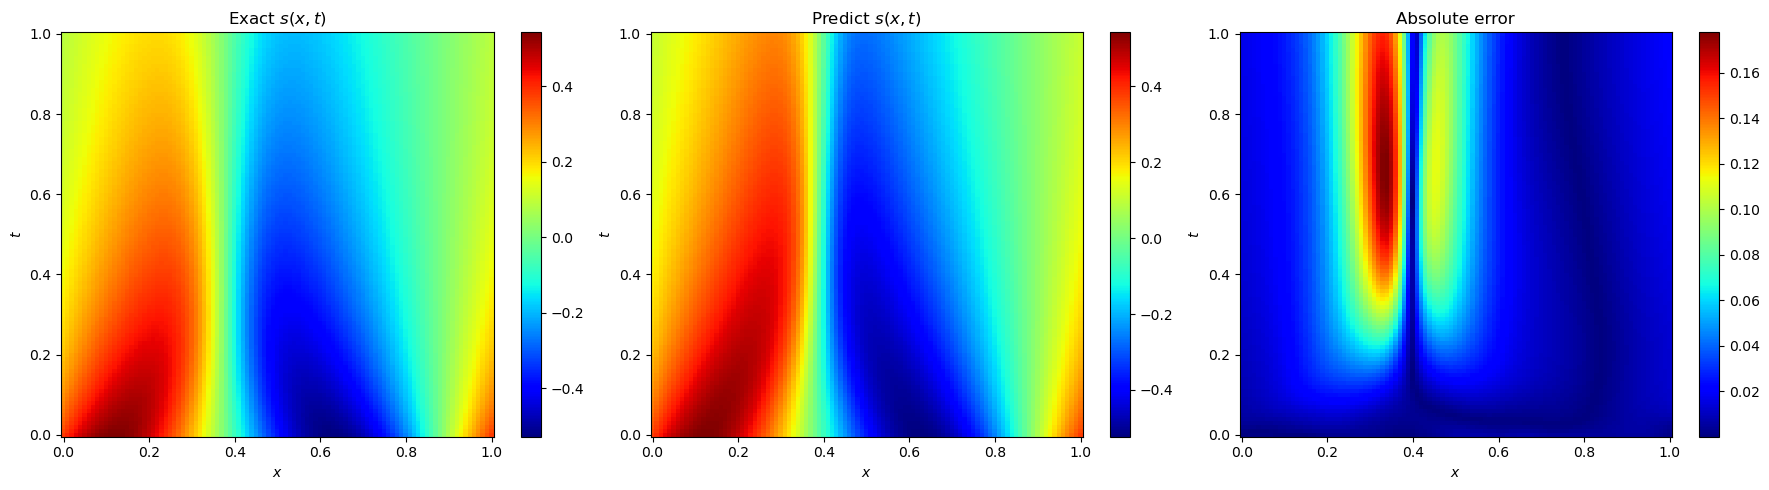

In [15]:
# Plot for one generated data
k = 1 # index, 0 means extrapolation prediction and 1 means interpolation prediction
u = usol[k,:, :]
u0 = usol[k,0,:]
v0 = usol_v[0]


P_test = 101

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]
v_test = np.tile(v0, (P_test**2, 1))
print(u_test.shape,y_test.shape,s_test.shape,v_test.shape)
s_pred = model.predict_s(params, u_test, y_test, v_test)[:,None]
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')
print(v_test)

error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2)

print("error_s: {:.3e}".format(error_s))

fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(T, X, u, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(T, X, S_pred.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(T, X, np.abs(S_pred.T - u), cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.show()

In [17]:
from scipy.io import savemat

data = {
    'inter_true': u.T,
    'inter_pred': S_pred
}

# save as .mat file
file_path = 'inter_test.mat'
savemat(file_path, data)

print(f"file has been saved as {file_path}")


文件已保存为 inter_test.mat


In [18]:
from scipy.io import savemat
data = {
    'extra_true': u.T,
    'extra_pred': S_pred
}

# save as .mat file
file_path = 'extra_test.mat'
savemat(file_path, data)

print(f"file has been saved as {file_path}")


文件已保存为 extra_test.mat
